### Data Extraction and Preprocessing 

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import gzip
import re
import seaborn as sns
import matplotlib.pyplot as plt


# Project Directory Layout
# ================================
# This notebook is in: preprocessing/
# Data is in:          data/raw/
# Output should go to:    data/processed_SINDy/

PROJECT_ROOT = Path("..")   # parent of preprocessing/
DATA_DIR = PROJECT_ROOT / "data"

RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed_SINDy"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_FILES = sorted(RAW_DIR.glob("*.txt.gz"))
len(RAW_FILES)


'# Paths (currently inside preprocessing/)\nRAW_DIR = Path("../notebooks/data/raw")\nPROCESSED_DIR = Path("../notebooks/data/processed_new")\nPROCESSED_DIR.mkdir(parents=True, exist_ok=True)\n\nRAW_FILES = sorted(RAW_DIR.glob("*.txt.gz"))\nlen(RAW_FILES)'

In [ ]:
# Look at the columns and contents of one of the .gz files
one = RAW_FILES[0]
df0 = pd.read_csv(one, sep="\t", compression="gzip", nrows=50, low_memory=False)
df0.columns.tolist()[:20]
df0.head(3)

,TYPE,text,text.1,text.2,text.3,integer,float,float.1,text.4,text.5,...,float.63,integer.58,integer.59,float.64,text.23,integer.60,integer.61,integer.62,integer.63,integer.64
0,FEPARAMS,Protocol_Name,Protocol_date,Scan_Date,Scan_ScannerName,Scan_NumChannels,Scan_MicronsPerPixelX,Scan_MicronsPerPixelY,Scan_OriginalGUID,Grid_Name,...,QCMetrics_MinReproducibility,QCMetrics_Formulation,QCMetrics_EnableDyeFlip,QCMetrics_PercentileValueForSignal,FeatureExtractor_Version,FeatureExtractor_SingleTextFileOutput,FeatureExtractor_JPEGDownSampleFactor,FeatureExtractor_ColorMode,FeatureExtractor_QCReportType,FeatureExtractor_OutputQCReportGraphText
1,DATA,GE1_107_Sep09 (Read Only),29-Sep-2009 12:35,11-23-2010 10:33:09,Agilent Technologies Scanner G2505B US45102984,1,5,5,b78b5053-6369-4e90-91da-2b2b004b82b5,026817_D_F_20100112ANNOTATED,...,50,2,0,75,10.7.1.1,1,4,0,0,0
2,*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

def parse_meta(fn: Path):
    # e.g., GSM1168586_BB0012_R_1.txt.gz
    name = fn.stem  # removes .gz
    if name.endswith(".txt"):
        name = name[:-4]
    m1 = re.match(r"(GSM\d+)_([A-Za-z0-9]+)_([RS])_(\d+)$", name)
    gsm, subj, cond, t_idx = m1.groups()
    return dict(gsm=gsm, subject=subj, condition=cond, t_idx=int(t_idx), file=str(fn))

files = RAW_FILES
meta = pd.DataFrame([parse_meta(f) for f in files]).sort_values(["subject","condition","t_idx"])
meta.head()
print("n samples:", len(meta))


n samples: 148


In [ ]:
# columns expected in Agilent one-color FE files
AGILENT_CANDIDATE_COLS = [
    "ProbeName", "SystematicName", "ControlType", "GeneName",
    "gProcessedSignal", "gMeanSignal", "gBGMedianSignal",
    "gIsWellAboveBG", "gIsPosAndSignif", "gNumPix"
]

def find_header_row_gz(path, max_lines=500):
    """
    Scan a (gzipped) text file for the first line that looks like the
    FEATURES header by checking for typical Agilent FE columns.
    Returns the zero-based line index of the header row.
    """
    opener = gzip.open if str(path).endswith(".gz") else open
    with opener(path, "rt", errors="ignore") as f:
        for i, line in enumerate(f):
            if i > max_lines:  # safety
                break
            cols = line.rstrip("\n").split("\t")
            # Heuristic: must contain 'ProbeName' and at least one g* signal column
            if "ProbeName" in cols and any(c in cols for c in ("gProcessedSignal","gMeanSignal")):
                return i
    return None

def read_agilent_fe(path: str | Path) -> pd.DataFrame:
    """
    Read an Agilent Feature Extraction .txt or .txt.gz into a DataFrame.
    Automatically locates the header row by column names.
    """
    path = Path(path)
    header_idx = find_header_row_gz(path)
    if header_idx is None:
        raise RuntimeError(f"Could not locate an Agilent FEATURES header in {path}")
    # pandas will treat the next line after skiprows as the header row
    df = pd.read_csv(
        path,
        sep="\t",
        compression="gzip" if str(path).endswith(".gz") else None,
        skiprows=header_idx,
        dtype=str,     # read as strings first (mixed types common), cast later
        low_memory=False
    )
    return df

# Example of using 
one = RAW_FILES[0]
df0 = read_agilent_fe(one)

# sanity check: the FE-like columns which are present
present = [c for c in AGILENT_CANDIDATE_COLS if c in df0.columns]
missing = [c for c in AGILENT_CANDIDATE_COLS if c not in df0.columns]
print("Present FE columns:", present)
print("Missing FE columns:", missing)
df0.head(3)

Present FE columns: ['ProbeName', 'SystematicName', 'ControlType', 'GeneName', 'gProcessedSignal', 'gMeanSignal', 'gBGMedianSignal', 'gIsWellAboveBG', 'gIsPosAndSignif', 'gNumPix']
Missing FE columns: []


,FEATURES,FeatureNum,Row,Col,chr_coord,accessions,SubTypeMask,SubTypeName,Start,Sequence,...,SpotExtentX,SpotExtentY,gNetSignal,gMultDetrendSignal,gProcessedBackground,gProcessedBkngError,IsUsedBGAdjust,gInterpolatedNegCtrlSub,gIsInNegCtrlRange,gIsUsedInMD
0,DATA,1,1,1,NaN,,260,BrightCorner,0,NaN,...,57.259,57.259,139029,0.810563,49.3102,9.17273,0,138987,0,0
1,DATA,2,1,2,NaN,,66,Structural,0,NaN,...,57.5363,57.5363,40.4795,0.813782,51.2922,7.81943,0,-1.22966,0,0
2,DATA,3,1,3,NaN,,66,Structural,0,NaN,...,48.5334,48.5334,40.2987,0.816876,52.1925,7.48548,0,-1.40499,0,0


In [5]:
INT_CHOICES  = ["gProcessedSignal","gMeanSignal","ProcessedSignal","Signal"]
PROBE_KEYS   = ["ProbeName","SystematicName","FeatureNum"]
GENE_KEYS    = ["GeneName","Gene Symbol","GENE_SYMBOL"]

def extract_expression(df):
    """
    From a full Agilent FE DataFrame, pull out only the useful columns:
      - intensity (gProcessedSignal)
      - probe ID
      - gene symbol (if present)
    and filter to real probes (ControlType == 0).
    """
    int_col  = next((c for c in INT_CHOICES if c in df.columns), None)
    probe_col= next((c for c in PROBE_KEYS   if c in df.columns), None)
    gene_col = next((c for c in GENE_KEYS    if c in df.columns), None)
    if int_col is None or probe_col is None:
        raise ValueError("Missing intensity or probe column")

    # keep only non-control probes if ControlType exists
    if "ControlType" in df.columns:
        df = df[df["ControlType"].astype(str) == "0"]

    out = df[[probe_col, int_col]].rename(columns={probe_col:"probe", int_col:"intensity"})
    if gene_col:
        out["gene"] = df[gene_col]
    return out.reset_index(drop=True)

dtest = extract_expression(df0)
dtest.shape
dtest.head()




,probe,intensity,gene
0,A_23_P67299,1.361813e+001,DOCK6
1,A_23_P49021,7.833045e+002,WDR61
2,A_24_P315975,4.684536e+000,KRTAP4-9
3,A_24_P109191,7.338431e+001,A_24_P109191
4,A_24_P269814,1.367563e+003,PLEKHA1


In [ ]:
files = RAW_FILES
expr_cols, probes_ref, genes_ref = [], None, None
gsm_ids = []  # sample IDs for columns

for f in files:
  """
  - Each .txt.gz file is one microarray analysis of a  biological sample = 1 test subject x 1 time point x 1 condition
  - Rows: Probes that map to specific genes
  - Columns: individual samples from each day
  - Distinguish the samples using metadata

  """
  df = read_agilent_fe(f)
  ex = extract_expression(df)

  if probes_ref is None:
      probes_ref = ex["probe"].to_numpy()
      genes_ref  = ex.get("gene", pd.Series([None]*len(ex))).to_numpy()
  else:
      # ensure same probe order across samples
      if not np.array_equal(ex["probe"].to_numpy(), probes_ref):
          raise ValueError(f"Probe order mismatch: {f.name}")

  expr_cols.append(ex["intensity"].astype(float).to_numpy())
  gsm_ids.append(Path(f).stem.split("_")[0])  # GSM id from filename

expr = pd.DataFrame(np.vstack(expr_cols).T, index=probes_ref, columns=gsm_ids)
gene_lookup = pd.Series(genes_ref, index=expr.index, name="gene")
expr.shape



(42119, 148)

In [7]:
expr.head()

,GSM1168586,GSM1168587,GSM1168588,GSM1168589,GSM1168590,GSM1168591,GSM1168592,GSM1168600,GSM1168601,GSM1168602,...,GSM1168849,GSM1168850,GSM1168851,GSM1168859,GSM1168860,GSM1168861,GSM1168862,GSM1168863,GSM1168864,GSM1168865
A_23_P67299,13.618130,12.207390,12.590030,10.713710,8.712199,9.536999,11.575380,27.646940,25.677860,24.001000,...,23.545380,28.935270,24.25344,24.420690,23.205040,14.757100,25.898890,20.577410,20.719090,15.304510
A_23_P49021,783.304500,444.073900,653.325400,568.109200,538.550800,401.755900,329.028800,771.243800,612.885800,760.890500,...,1080.137000,1011.804000,1086.29600,850.500900,1155.626000,655.535100,801.070500,742.433800,493.854200,641.322200
A_24_P315975,4.684536,4.149376,4.803894,4.167126,4.695851,4.673196,3.819112,6.086557,3.978043,2.473457,...,3.586226,4.850235,6.18321,2.776423,2.818262,2.860632,2.835793,2.997644,3.004665,2.854092
A_24_P109191,73.384310,51.695910,58.340990,58.372150,67.240610,51.779730,63.039440,27.924780,24.190640,24.542800,...,29.211740,26.983900,24.31742,23.919450,31.453100,23.931710,29.049270,21.515050,22.850090,25.143650
A_24_P269814,1367.563000,922.976400,1361.948000,745.848100,819.361600,679.402500,586.827900,870.039900,553.392800,719.579000,...,1602.221000,1573.269000,1683.29800,1095.426000,1469.391000,911.040100,1123.815000,899.250200,878.235500,916.816100


In [8]:
"""
Created a probe by samples matrix (with intensities as the values)
Apply log2 transform and quantile normalization across samples
Remove NaNs
"""
# log2
# Stabilize variance and make multiplicative effects additive
expr_log2 = np.log2(expr.clip(lower=1.0)) # clips avoids log(0) edge cases

# quantile normalization across samples
def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    QN: sort each column, take the row-wise mean across columns,
    then map those means back to the original ranks using a stable inverse argsort.
    Works with ties and preserves index/columns.
    """
    X = df.values
    n_rows, n_cols = X.shape

    # argsort each column (stable)
    sort_idx = np.argsort(X, axis=0, kind="mergesort")
    # sorted values per column
    X_sorted = np.take_along_axis(X, sort_idx, axis=0)
    # mean across columns at each rank
    mean_sorted = X_sorted.mean(axis=1, keepdims=True)

    # build inverse permutation per column
    inv = np.empty_like(sort_idx)
    for j in range(n_cols):
        inv[sort_idx[:, j], j] = np.arange(n_rows)

    # map rank means back to original order
    X_qn = np.take_along_axis(mean_sorted, inv, axis=0)

    return pd.DataFrame(X_qn, index=df.index, columns=df.columns)

expr_qn = quantile_normalize(expr_log2)

# drop non-genes and collapse probes into genes (median)
mask = gene_lookup.notna() & (gene_lookup.str.strip()!="")
expr_qn_g = expr_qn.loc[mask]
gene_lu    = gene_lookup.loc[mask]
expr_gene  = (expr_qn_g.assign(gene=gene_lu.values)
                        .groupby("gene", sort=False).median())
expr_gene.shape


(29872, 148)

In [9]:
expr.head()

,GSM1168586,GSM1168587,GSM1168588,GSM1168589,GSM1168590,GSM1168591,GSM1168592,GSM1168600,GSM1168601,GSM1168602,...,GSM1168849,GSM1168850,GSM1168851,GSM1168859,GSM1168860,GSM1168861,GSM1168862,GSM1168863,GSM1168864,GSM1168865
A_23_P67299,13.618130,12.207390,12.590030,10.713710,8.712199,9.536999,11.575380,27.646940,25.677860,24.001000,...,23.545380,28.935270,24.25344,24.420690,23.205040,14.757100,25.898890,20.577410,20.719090,15.304510
A_23_P49021,783.304500,444.073900,653.325400,568.109200,538.550800,401.755900,329.028800,771.243800,612.885800,760.890500,...,1080.137000,1011.804000,1086.29600,850.500900,1155.626000,655.535100,801.070500,742.433800,493.854200,641.322200
A_24_P315975,4.684536,4.149376,4.803894,4.167126,4.695851,4.673196,3.819112,6.086557,3.978043,2.473457,...,3.586226,4.850235,6.18321,2.776423,2.818262,2.860632,2.835793,2.997644,3.004665,2.854092
A_24_P109191,73.384310,51.695910,58.340990,58.372150,67.240610,51.779730,63.039440,27.924780,24.190640,24.542800,...,29.211740,26.983900,24.31742,23.919450,31.453100,23.931710,29.049270,21.515050,22.850090,25.143650
A_24_P269814,1367.563000,922.976400,1361.948000,745.848100,819.361600,679.402500,586.827900,870.039900,553.392800,719.579000,...,1602.221000,1573.269000,1683.29800,1095.426000,1469.391000,911.040100,1123.815000,899.250200,878.235500,916.816100


In [10]:
expr_gene_z = expr_gene.apply(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-8), axis=1)

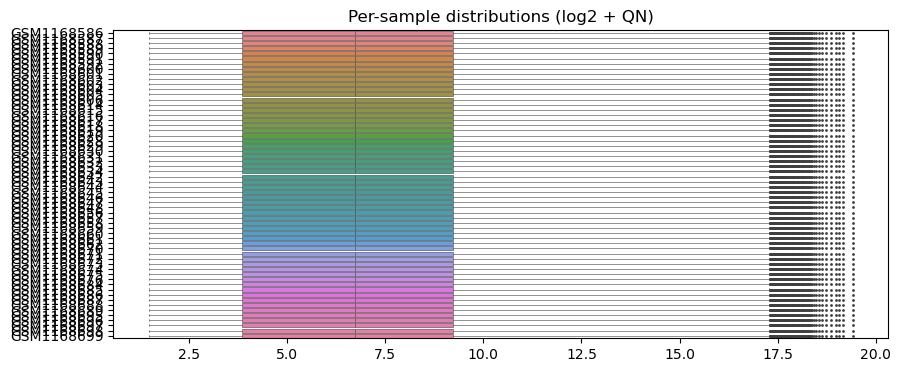

In [11]:
"""
Diagnostic plot to confirm that log2 + quantile normalization worked.
If correct, the variance and mean should align (boxes for each sample must align)
"""

plt.figure(figsize=(10,4))
sns.boxplot(data=expr_qn.iloc[:, :min(60, expr_qn.shape[1])], orient="h", fliersize=1, linewidth=0.4)
plt.title("Per-sample distributions (log2 + QN)")
plt.show()


c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


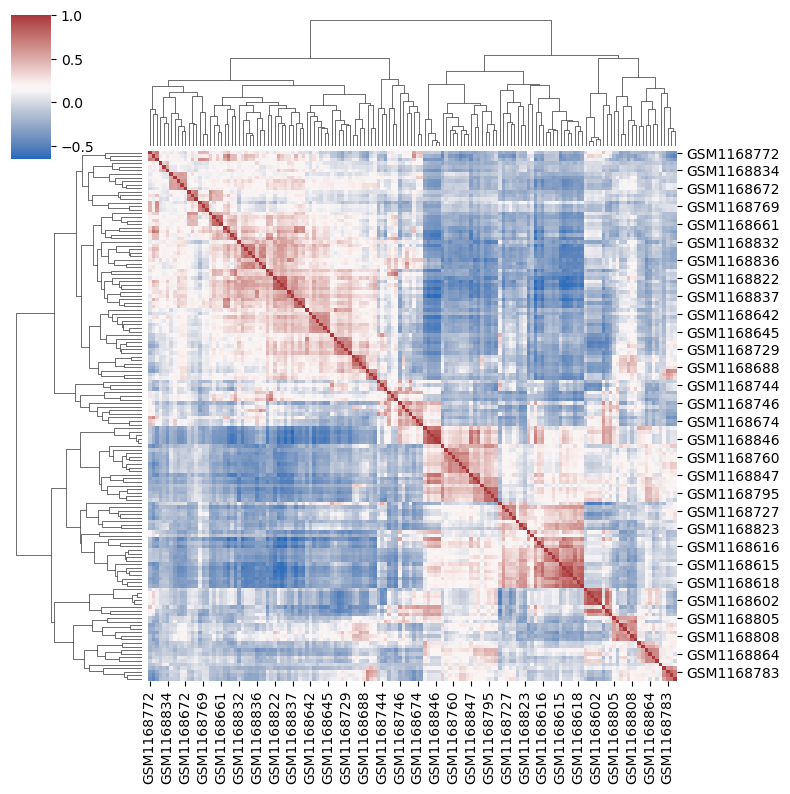

In [12]:
# Should we delete??
var_genes = expr_gene_z.var(axis=1).nlargest(2000).index
X = expr_gene_z.loc[var_genes]
#Xz = X.apply(lambda s: (s - s.mean())/(s.std(ddof=0)+1e-8), axis=1)
corr = X.corr(method="pearson")

sns.clustermap(corr, cmap="vlag", figsize=(8,8))

<Axes: xlabel='t_idx', ylabel='expr'>

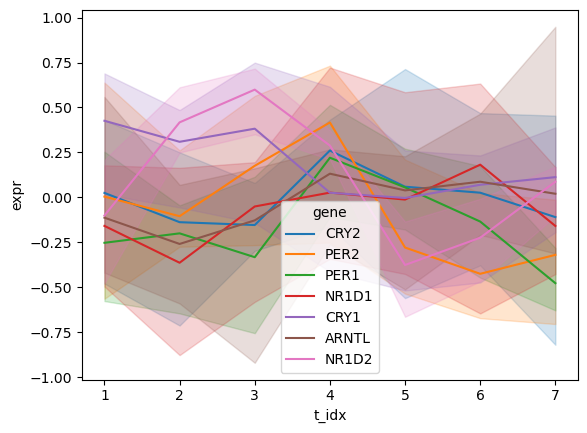

In [13]:
"""
Plotting select Circadian Rhythm-associated genes' expression values over time.
"""

CORE = ["PER1","PER2","CRY1","CRY2","ARNTL","BMAL1","NR1D1","NR1D2"]
long = (expr_gene_z.loc[expr_gene_z.index.intersection(CORE)]
        .stack().rename("expr").reset_index().rename(columns={"level_1":"gsm"}))
long = long.merge(meta[["gsm","subject","condition","t_idx"]], on="gsm", how="left")
sns.lineplot(data=long, x="t_idx", y="expr", hue="gene",
             estimator="median", errorbar=("ci",95))


c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


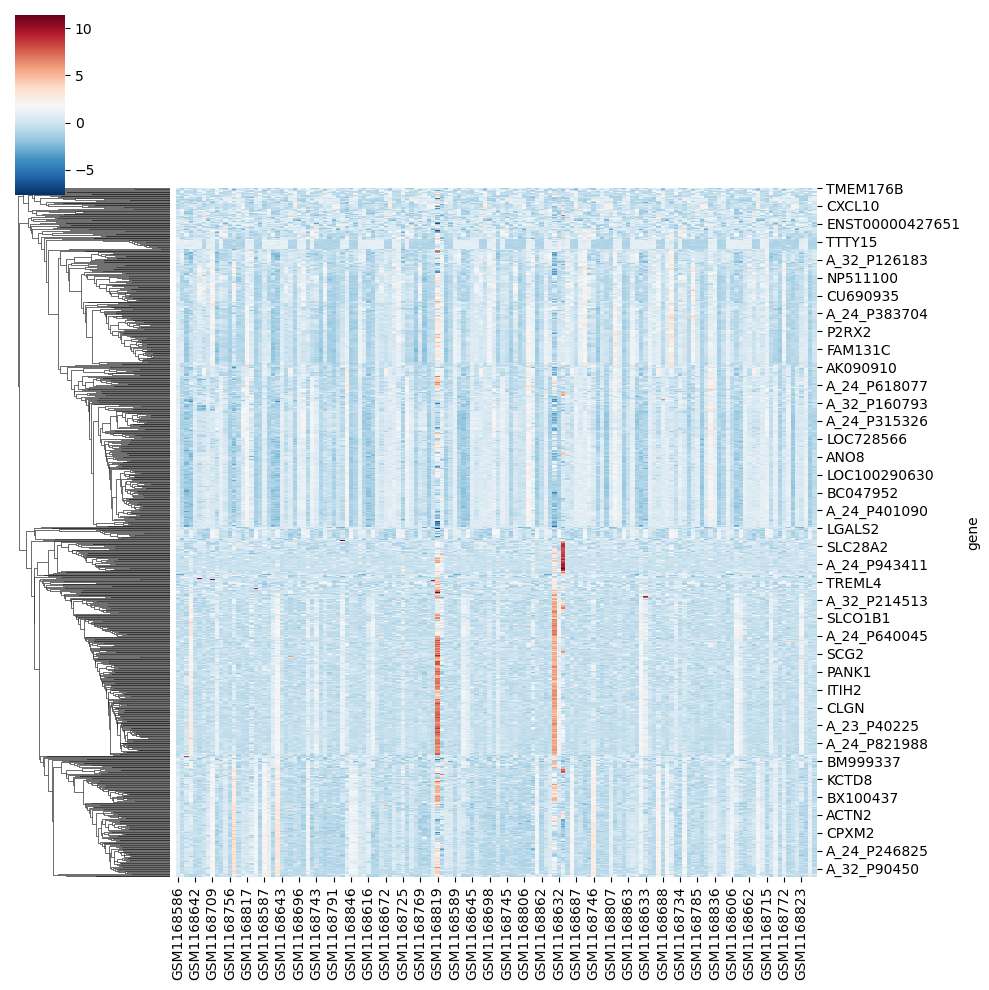

In [ ]:
# columns ordered by (condition, t_idx)
"""
Plotting a clustermap of genes w.r.t. the samples on the horizontal axis (samples are from different days i.e. horizontal axis is the time)
"""
order = meta.sort_values(["condition","t_idx"])["gsm"]
sns.clustermap(expr_gene_z[order].loc[expr_gene_z.var(axis=1).nlargest(1000).index],
               col_cluster=False, cmap="RdBu_r", z_score=0, figsize=(10,10))


<Axes: xlabel='PC1', ylabel='PC2'>

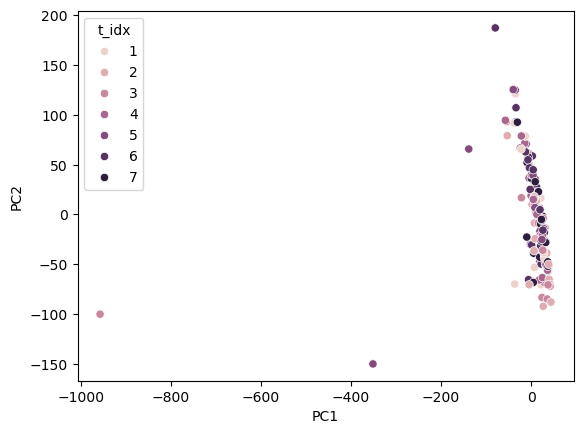

In [15]:
"""
Verify the PCA analysis
"""
from sklearn.decomposition import PCA
Z = PCA(n_components=2).fit_transform(expr_gene_z.T)
pc = pd.DataFrame(Z, columns=["PC1","PC2"]).assign(gsm=expr_gene_z.columns)
pc = pc.merge(meta, on="gsm", how="left")
sns.scatterplot(data=pc, x="PC1", y="PC2", hue="t_idx")

In [ ]:
# Save files:

expr_gene_z.to_pickle(PROCESSED_DIR / "expr_gene_log2_qn_zscaled.pkl")
expr_gene_z.to_csv(PROCESSED_DIR / "expr_gene_log2_qn_zscaled.csv")
meta.to_csv(PROCESSED_DIR / "meta.csv")


'expr_gene_z.to_pickle("../notebooks/data/processed_new/expr_gene_log2_qn_zscaled.pkl")\nexpr_gene_z.to_csv("../notebooks/data/processed_new/expr_gene_log2_qn_zscaled.csv")\nmeta.to_csv("../notebooks/data/processed_new/meta.csv")'